# Purpose:

Try to analyse the data-clustering-structure by vizualisation by using UMAP - projections. <br>
We use different encoding/ embedding techniques on the data and project to 2D with the UMAP-projection. <br>
Doing so we hopefully find a hint, which type of encoding/ embedding algorithm is most suitable to this dataset. <br>

# Load Data

In [1]:
import umap.umap_ as umap
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import LabelEncoder
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# Load Data:
df = pd.read_csv("../data/sachkonto_positionstexte.csv")
X = df["Positionstext"].tolist()
y = df["Sachkonto"].tolist()
print(df.head(3))

   Sachkonto Sachkontobeschreibung                       Positionstext
0     400000         Waren-Eingang  Wareneingang Lieferung Müller GmbH
1     400000         Waren-Eingang            Rechnung über Bürobedarf
2     400000         Waren-Eingang             Lieferung Druckerpapier


# Code - Functions

In [2]:
def get_umap_Doc2Vec(documents):
    """
    returns the umap-projections of doc2vec embedded documents.
    documents : the documents to be embedded and projected
    """
    # tagging and training Doc2Vec:
    docs = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(documents)]
    d2v_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=40)
    d2v_model.build_vocab(docs)
    d2v_model.train(docs, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

    # create vectors:
    vectors = np.array([d2v_model.infer_vector(doc.words) for doc in docs])

    # UMAP-projection:
    umap_projector = umap.UMAP(random_state=42)
    projections = umap_projector.fit_transform(vectors)

    return projections


def get_umap_tf_idf_pca(documents):
    """
    Returns UMAP projections from TF-IDF encoded PCA dimension-reduced documents.
    """

    tfidf = TfidfVectorizer()
    # tf-idf encoding:
    docs_tfidf = tfidf.fit_transform(documents)
    # pca:
    docs_pca = PCA(n_components=2).fit_transform(docs_tfidf.toarray())

    # UMAP-projection:
    umap_projector = umap.UMAP(random_state=42)
    projections = umap_projector.fit_transform(docs_pca)

    return projections


def get_umap_tf_idf(documents):
    """
    Returns UMAP projections directly from TF-IDF encoded documents.
    """
    tfidf = TfidfVectorizer()
    docs_tfidf = tfidf.fit_transform(documents)

    umap_projector = umap.UMAP(random_state=42)
    projections = umap_projector.fit_transform(docs_tfidf.toarray())

    return projections


def get_sbert_umap(documents):
    """
    Uses a pretrained Sentence-BERT model to get semantic embeddings and returns their UMAP projection.
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(documents)
    umap_projector = umap.UMAP(random_state=42)
    projections = umap_projector.fit_transform(embeddings)
    return projections


def umap_plot(documents, targets, projection_function, plot_title="Plot_title"):
    """
    Applies the projection_function to the documents and plots the result.
    """
    projections = projection_function(documents)
    # Label-Encoding of targets:
    le = LabelEncoder()
    y_encoded = le.fit_transform(targets)
    label_names = le.classes_
    # Plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=projections[:, 0],
        y=projections[:, 1],
        hue=[label_names[label] for label in y_encoded],
        palette="tab10",
        s=60,
        alpha=0.8,
        edgecolor="k"
    )
    plt.title(f"{plot_title}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def inspect_cluster(documents, targets, projection_function, xmin, xmax, ymin, ymax):
    """
    Returns 'Positionstext' and 'Sachkonto' for the documents/ line-item texts that
    have been projected into the given coordinate-square by the given projection_function.
    I.e. this function acts like the local inverse of the projection_function.
    """
    projections = projection_function(documents)
    df_plot = pd.DataFrame({
        "x": projections[:, 0],
        "y": projections[:, 1],
        "Positionstext": documents,
        "Sachkonto": targets
    })
    cluster = df_plot[(df_plot["x"] >= xmin) & (df_plot["x"] <= xmax) &
                      (df_plot["y"] >= ymin) & (df_plot["y"] <= ymax)]
    return cluster.reset_index(drop=True)

# Experiments

## Visualisierung UMAP - Doc2Vec

c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


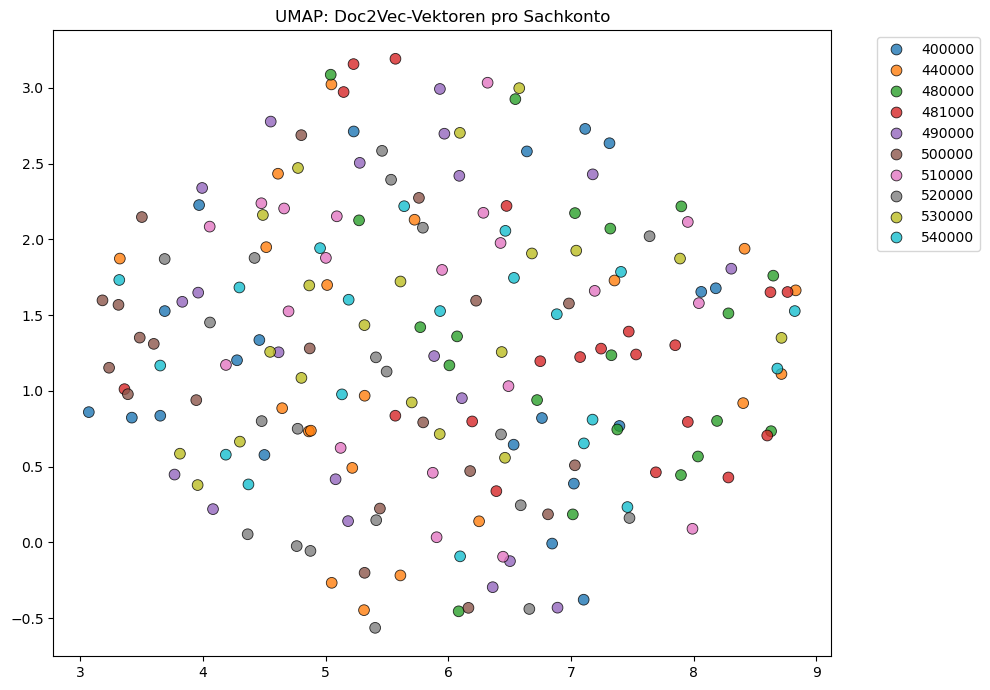

In [3]:
umap_plot(X, y, get_umap_Doc2Vec, "UMAP: Doc2Vec-Vektoren pro Sachkonto")

Abbildung zeigt: <br>
- gleichmässige Verteilung der Daten, keine auffälligen Cluster
- keine nennenswerten Cluster in irgendeiner Farbe <br>

<br>Fazit:<br>
Doc2Vec kann keine Ähnlichkeiten oder sonstige (thematische) Strukturen erkennen.

## Visualisierung UMAP - TF-IDF mit PCA

c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


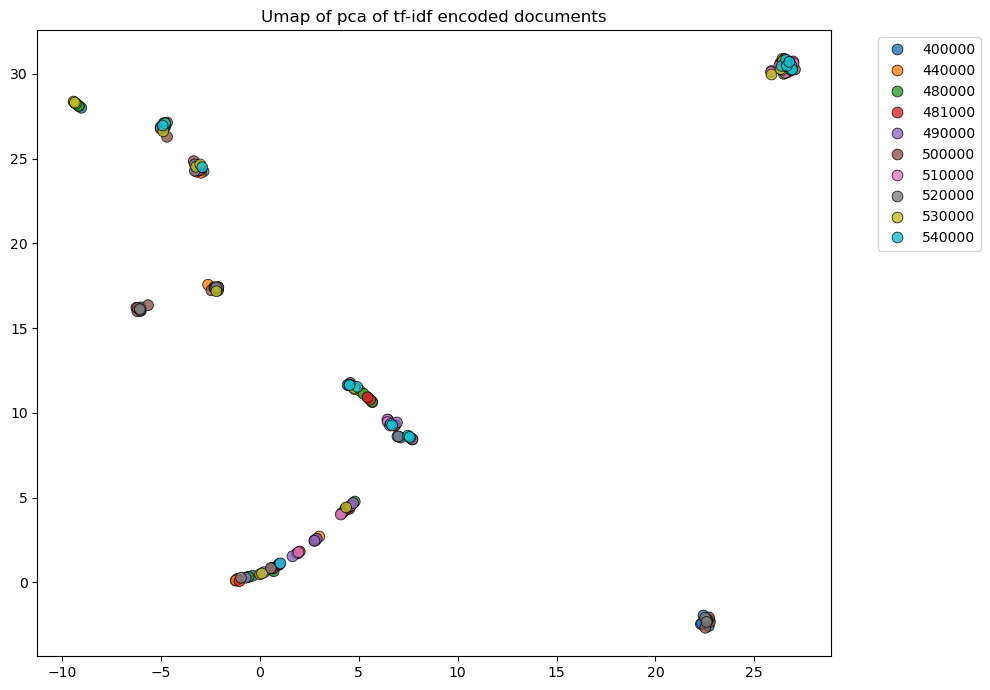

In [4]:
umap_plot(X, y, get_umap_tf_idf_pca, "Umap of pca of tf-idf encoded documents")

Abbildung zeigt: <br>
- klare Cluster, aber nicht nach Klassen getrennt
 <br>

<br>Fazit:<br>
tfidf-pca kann Ähnlichkeiten erkennen, aber nicht den Klassen eindeutig zuordnen.

## Visualisierung UMAP - TF-IDF

c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


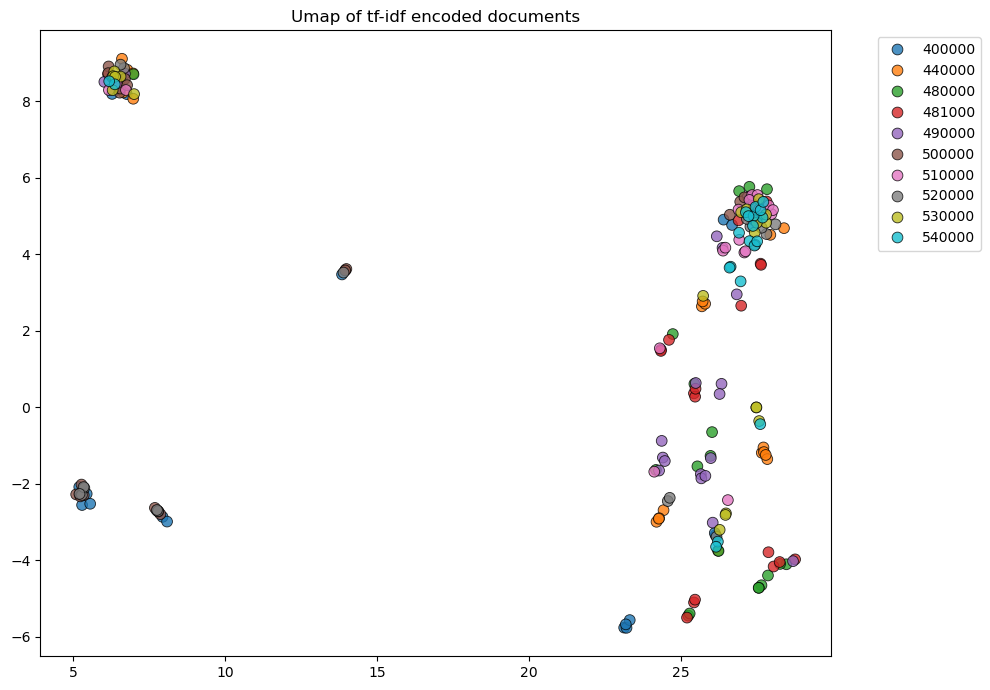

In [5]:
umap_plot(X, y, get_umap_tf_idf, "Umap of tf-idf encoded documents")

Abbildung zeigt: <br>
- klare Cluster
- Cluster stark durchmischt
- vereinzelt stimmen Cluster mit Klassen überein.
 <br>

<br>Fazit:
Worthäufigkeiten reichen nicht aus, um Klassen eindeutig zu bestimmen.

### Cluster-Analysis - "What is in a Cluster"

In the "Umap of tf-idf encoded documents" plot we have several mixed clusters. To analyse, what is in a cluster we use the "inspect_cluster" function, with the boundary coordinates from the above plot. This might help to understand the problem, why so many classes are mixed in this cluster.

In [6]:
cluster_df = inspect_cluster(
    documents=X,
    targets=y,
    projection_function=get_umap_tf_idf,
    xmin=23, xmax=27,
    ymin=4, ymax=6
)
print(cluster_df[["Positionstext", "Sachkonto"]])


c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


                  Positionstext  Sachkonto
0    Anlieferung Kugelschreiber     400000
1    Rechnung Hefter und Locher     400000
2                Taxi zur Messe     480000
3           Flug nach Amsterdam     481000
4    Geschäftsessen Projektteam     490000
5           Getränke und Snacks     490000
6             Toner-Nachfüllung     500000
7   Büromaterial Kugelschreiber     500000
8              Telefon Flatrate     510000
9         Telefonkosten Hotline     510000
10              DSL und Telefon     510000
11   SIM-Karte Geschäftsführung     510000
12           Update Virenschutz     530000
13    Coaching Geschäftsführung     540000


Die Texte im Cluster gehören thematisch zum Teil zusammen, sind aber auch dann auf verschiedene Sachkonten aufgeteilt: Büromaterial (auf Sachkonten 40 UND 50), Reise (48 UND 481). <br>
Es ist daher klar, dass eine reine Häufigkeitsanalyse ohne Betrachtung der Bedeutung nicht weiter führen wird.

## Visualisierung Sentence-Transformer

c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


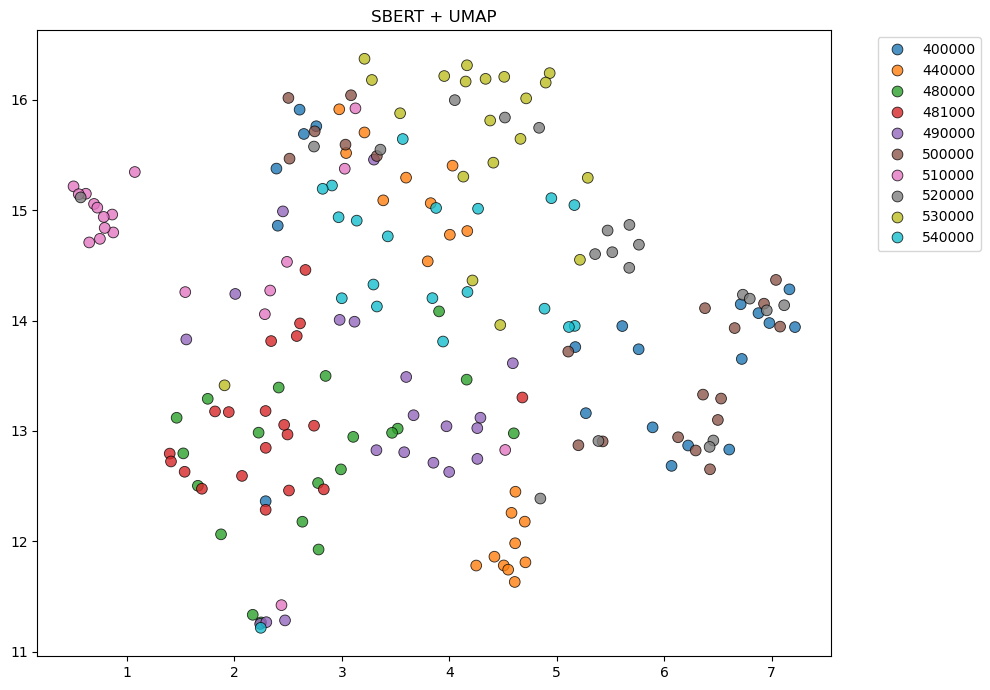

In [7]:
umap_plot(X, y, get_sbert_umap, plot_title="SBERT + UMAP")


There are some pure clusters of class 51 and class 44 entities and areas where mainly the entities of one class are positioned, though not yet densely clustered. Based on this, we could try a classification on Bert or on Bert + Umap preparatory data transformations.